In [2]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

In [43]:
with open('/content/BTC_hist_daily_prices.json') as json_file:
    data = json.load(json_file)

df = pd.DataFrame(data['Data']['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
df = df.drop(['conversionType', 'conversionSymbol'], axis=1 )
target_col = 'close'

df.head(100)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2010-07-17,0.04951,0.04951,0.04951,20.00,0.9902,0.04951
2010-07-18,0.08585,0.05941,0.04951,75.01,5.0920,0.08584
2010-07-19,0.09307,0.07723,0.08584,574.00,49.6600,0.08080
2010-07-20,0.08181,0.07426,0.08080,262.00,20.5900,0.07474
2010-07-21,0.07921,0.06634,0.07474,575.00,42.2600,0.07921
...,...,...,...,...,...,...
2010-10-20,0.10300,0.09400,0.09700,31855.00,3221.0800,0.09900
2010-10-21,0.10900,0.09700,0.09900,44867.00,4616.8500,0.10700
2010-10-22,0.10900,0.10150,0.10700,34603.91,3665.4300,0.10250


In [44]:
# Normalize values between 0-1 for every feature (each column is divided by column max value).

scaler = MinMaxScaler()
array_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(array_scaled, columns=df.columns,index=df.index)
df_scaled.head()

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2010-07-17,0.000000,0.000002,0.000000,0.000035,1.585403e-10,0.000000
2010-07-18,0.000002,0.000003,0.000000,0.000131,8.152768e-10,0.000002
2010-07-19,0.000002,0.000004,0.000002,0.001003,7.951030e-09,0.000002
2010-07-20,0.000002,0.000003,0.000002,0.000458,3.296651e-09,0.000001
2010-07-21,0.000001,0.000003,0.000001,0.001005,6.766221e-09,0.000002


In [66]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train_orig, test_orig = train_test_split(df, test_size=0.2)
train, test = train_test_split(df_scaled, test_size=0.2)

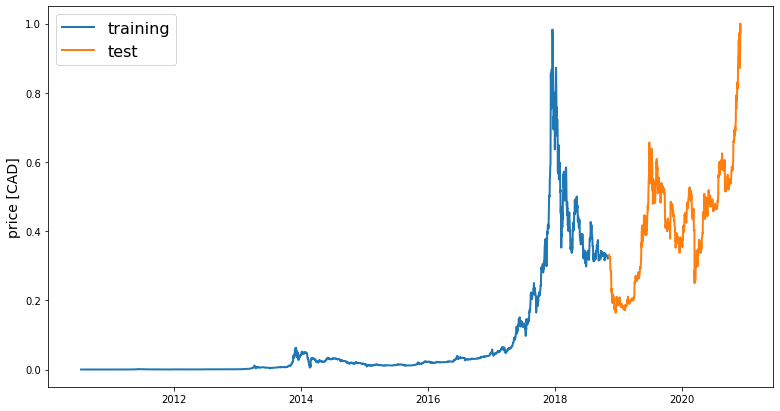

In [46]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [47]:
def extract_window_data(df, window_len=5):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp.values)
    
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len)
    X_test = extract_window_data(test_data, window_len)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values

    return train_data, test_data, X_train, X_test, y_train, y_test

def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape =(input_data.shape[1],input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [48]:
np.random.seed(42)
window_len = 5
test_size = 0.2
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [62]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df_scaled, target_col, window_len=window_len, test_size=test_size)

In [63]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
95/95 [==============================] - 2s 3ms/step - loss: 0.0046
Epoch 2/20
95/95 [==============================] - 0s 3ms/step - loss: 5.5989e-04
Epoch 3/20
95/95 [==============================] - 0s 4ms/step - loss: 3.3552e-04
Epoch 4/20
95/95 [==============================] - 0s 3ms/step - loss: 4.4072e-04
Epoch 5/20
95/95 [==============================] - 0s 3ms/step - loss: 3.8377e-04
Epoch 6/20
95/95 [==============================] - 0s 3ms/step - loss: 3.5627e-04
Epoch 7/20
95/95 [==============================] - 0s 3ms/step - loss: 3.2542e-04
Epoch 8/20
95/95 [==============================] - 0s 3ms/step - loss: 3.3483e-04
Epoch 9/20
95/95 [==============================] - 0s 3ms/step - loss: 2.8921e-04
Epoch 10/20
95/95 [==============================] - 0s 3ms/step - loss: 2.3941e-04
Epoch 11/20
95/95 [==============================] - 0s 3ms/step - loss: 3.1159e-04
Epoch 12/20
95/95 [==============================] - 0s 3ms/step - loss: 2.6411e-04
Epoch

In [68]:
preds = model.predict(X_test).squeeze()

arr = np.zeros([preds.shape[0], 6])
arr[:, 5] = preds

res = scaler.inverse_transform(arr)

df_res = pd.DataFrame(res, columns=df.columns)

df_res.head()

,high,low,open,volumefrom,volumeto,close
0,0.04951,0.01,0.04951,0.0,0.0,6677.259687
1,0.04951,0.01,0.04951,0.0,0.0,6656.014810
2,0.04951,0.01,0.04951,0.0,0.0,6619.991220
3,0.04951,0.01,0.04951,0.0,0.0,6596.626550
4,0.04951,0.01,0.04951,0.0,0.0,6568.669090


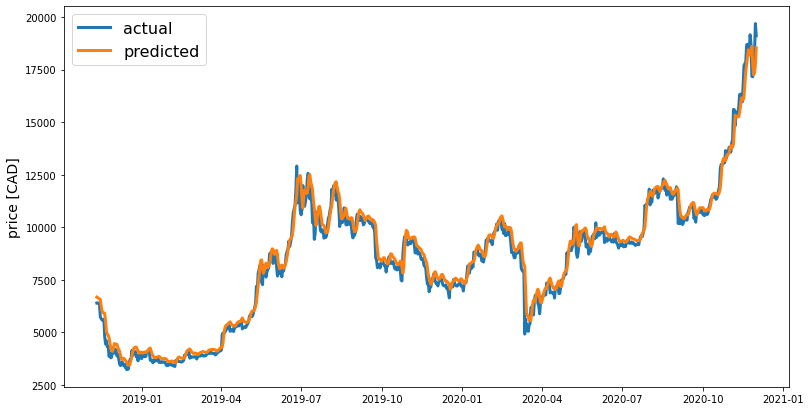

In [69]:
predicted_closing_prices = df_res[target_col].values
actual_closing_prices = test_orig[target_col][window_len:]

predicted_closing_prices = pd.Series(index=actual_closing_prices.index, data=predicted_closing_prices)

line_plot(actual_closing_prices, predicted_closing_prices, 'actual', 'predicted', lw=3)